In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [45]:

from mglvq import MGLVQ as MGLVQ # Original Version mit tracking
from mglvq_uneven import MGLVQ as MGLVQ_uneven # Original Version mit tracking & uneven

from vmglvq_dietlind import VMGLVQ as vMGLVQ_dietlind # Original Version Dietlind Fehlermeldung unterdrückt
from vmglvq_tracking import VMGLVQ as vMGLVQ  # Original Version Dietlind mit tracking
from vmglvq_uneven_prototype_numbers import VMGLVQ as vMGLVQ_uneven # Angepasste Version mit weight initialization, uneven & tracking


In [3]:
from functions import (
    align_square_matrix_to_df_order,
    align_matrices_to_df,
    visualize_from_distance_and_model,
    plot_training_overview,
)

2025-11-09 07:48:47.003414: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-09 07:48:47.017137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-09 07:48:47.032376: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-09 07:48:47.036950: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-09 07:48:47.047890: I tensorflow/core/platform/cpu_feature_guar

# read data

## y

In [47]:
y_df_0201_original = pd.read_pickle('data/0201.pkl')
y_df_0201_optimized = pd.read_pickle('data/0201_optimized.pkl')

y_df_0601_original = pd.read_pickle('data/0601.pkl')
y_df_0601_optimized = pd.read_pickle('data/0601_optimized.pkl')

y_df_0602_original = pd.read_pickle('data/0602.pkl')
y_df_0602_optimized = pd.read_pickle('data/0602_optimized.pkl')

y_df_0604_original = pd.read_pickle('data/0604.pkl')
y_df_0604_optimized = pd.read_pickle('data/0604_optimized.pkl')

In [5]:
dfs = {
    "y_df_0201_original":  y_df_0201_original,
    "y_df_0201_optimized": y_df_0201_optimized,
    "y_df_0601_original":  y_df_0601_original,
    "y_df_0601_optimized": y_df_0601_optimized,
    "y_df_0602_original":  y_df_0602_original,
    "y_df_0602_optimized": y_df_0602_optimized,
    "y_df_0604_original":  y_df_0604_original,
    "y_df_0604_optimized": y_df_0604_optimized,
}

for name, df in dfs.items():
    print(f"{name}: {len(df)}")

y_df_0201_original: 2042
y_df_0201_optimized: 1832
y_df_0601_original: 2042
y_df_0601_optimized: 1890
y_df_0602_original: 2042
y_df_0602_optimized: 1798
y_df_0604_original: 2042
y_df_0604_optimized: 1855


## matrizes

In [50]:
D_weighted_sub_p = pd.read_pickle('data/D_weighted_sub_p.pkl')
D_naics_sub_p = pd.read_pickle('data/D_naics_sub_p.pkl')
D_hs_sub_p = pd.read_pickle('data/D_hs_sub_p.pkl')
D_am_sub_p =pd.read_pickle('data/D_am_sub_p.pkl')
D_geo_sub_p = pd.read_pickle('data/D_geo_sub_p.pkl')
D_numeric_sub_p = pd.read_pickle('data/D_numeric_sub_p.pkl')

In [51]:
mats = {
    "D_weighted_sub_p": D_weighted_sub_p,
    "D_naics_sub_p":    D_naics_sub_p,
    "D_hs_sub_p":       D_hs_sub_p,
    "D_am_sub_p":       D_am_sub_p,
    "D_geo_sub_p":      D_geo_sub_p,
    "D_numeric_sub_p":  D_numeric_sub_p,
}

for name, D in mats.items():
    print(f"{name}: shape={D.shape}")

D_weighted_sub_p: shape=(2042, 2042)
D_naics_sub_p: shape=(2042, 2042)
D_hs_sub_p: shape=(2042, 2042)
D_am_sub_p: shape=(2042, 2042)
D_geo_sub_p: shape=(2041, 2041)
D_numeric_sub_p: shape=(1451, 1451)


# preparation

## MGLVQ

In [52]:
# test
y_df = y_df_0201_optimized
D_sorted = align_square_matrix_to_df_order(D_weighted_sub_p, y_df, id_col="CustomerCode", return_numpy=False)
display(len(y_df))
display(D_sorted.shape)

1832

(1832, 1832)

## vMGLVQ

In [53]:
#test
mats = {
    "D_weighted_sub": D_weighted_sub_p,
    "D_naics_sub":    D_naics_sub_p,
    "D_hs_sub":       D_hs_sub_p,
    "D_am_sub":       D_am_sub_p,
    "D_geo_sub":      D_geo_sub_p,
}

y_df = y_df_0201_optimized


aligned_np, y_df_cut, ordered_ids = align_matrices_to_df(
    mats, y_df, id_col="CustomerCode",
    matrices_as_numpy=True, set_globals=True
)

# Matrizen als Variablen sichern (NumPy-Arrays, weil matrices_as_numpy=True)
D_weighted_sub_p_aligned = aligned_np["D_weighted_sub"]
D_naics_sub_p_aligned    = aligned_np["D_naics_sub"]
D_hs_sub_p_aligned       = aligned_np["D_hs_sub"]
D_am_sub_p_aligned       = aligned_np["D_am_sub"]
D_geo_sub_p_aligned      = aligned_np["D_geo_sub"]


[1] KGN (Schnittmenge über alle Matrizen): 2041 IDs
[2] DF gekürzt auf KGN: 1831 Zeilen | eindeutige IDs in DF-Reihenfolge: 1831
[3] D_weighted_sub_p_aligned -> (1831, 1831) (ndarray)
[3] D_naics_sub_p_aligned -> (1831, 1831) (ndarray)
[3] D_hs_sub_p_aligned -> (1831, 1831) (ndarray)
[3] D_am_sub_p_aligned -> (1831, 1831) (ndarray)
[3] D_geo_sub_p_aligned -> (1831, 1831) (ndarray)
[4] df_cut -> Series mit Name '0201' und Länge 1831


# prediction

## MGLVQ

### Original

In [54]:
y_df = y_df_0201_optimized
D_sorted = align_square_matrix_to_df_order(D_weighted_sub_p, y_df, id_col="CustomerCode", return_numpy=True)
display(len(y_df))
display(D_sorted.shape)

1832

(1832, 1832)

In [55]:
model = MGLVQ(K= 3, T=50, track_path=True)
D = D_sorted
y = np.asarray(y_df['0201'].to_numpy().astype(int))
model.fit(D, y)
display(model.score(D, y))

0.6566593886462883

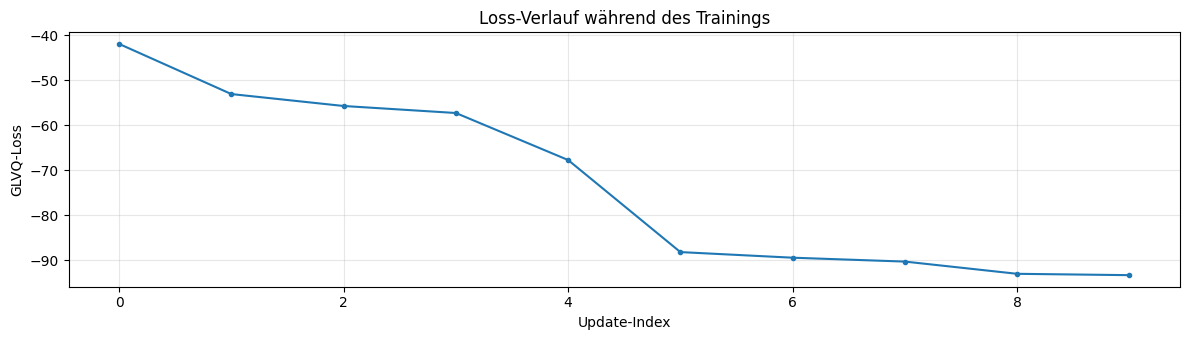

In [56]:
fig = plot_training_overview(model, smooth_v=0, show=False, return_fig=True)

/home/pmlb/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pmlb/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pmlb/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/pmlb/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


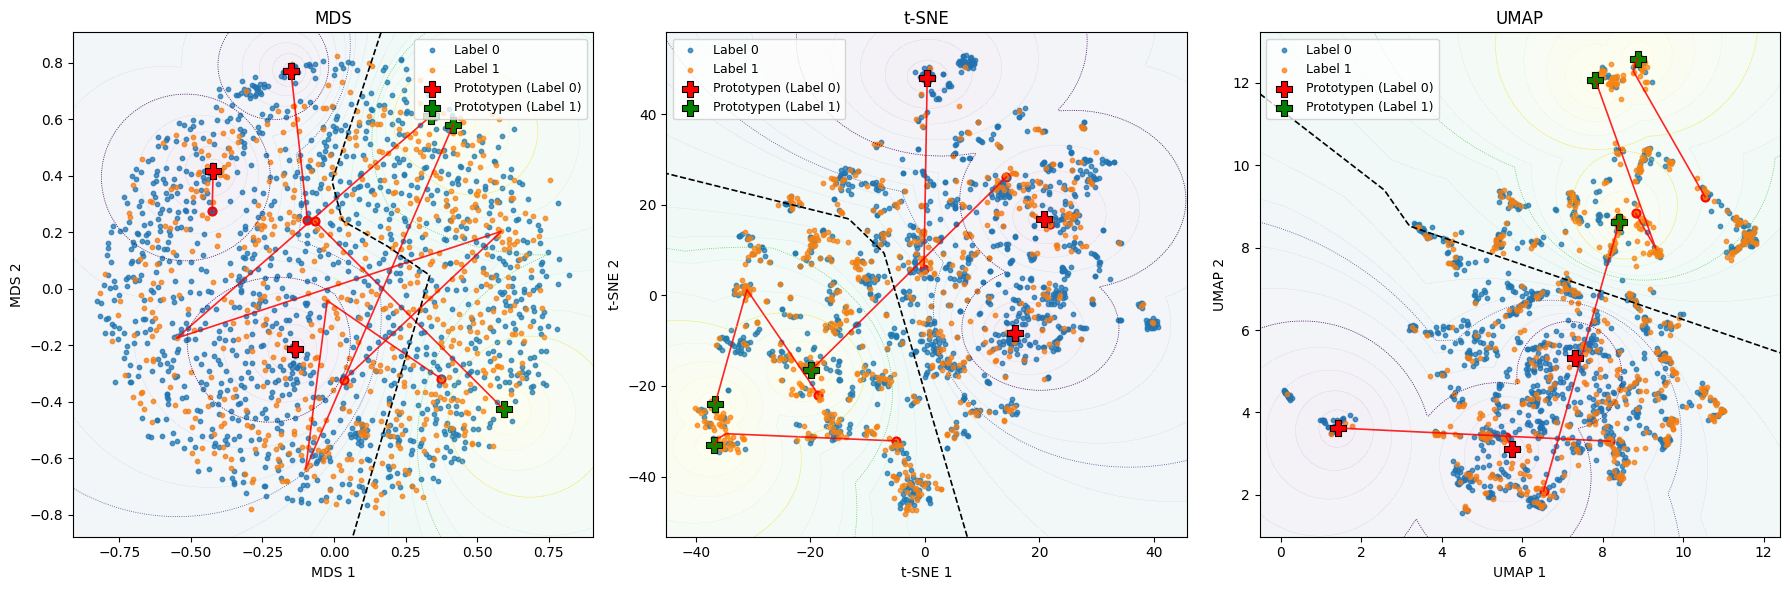

In [57]:
D = D_sorted
path = Path("embeddings/0201/one_matrix/weighted.npy")
fig, axes, embeds = visualize_from_distance_and_model(
    model, D, y,
    use_classical_mds=False,
    mds_load_path=path if path.exists() else None,
    mds_save_path="emb_store/mds_pre/A.npy"
)


### Uneven

In [16]:
model = MGLVQ_uneven(K={0: 3, 1: 7}, T=50, track_path=True)
D = D_sorted
y = np.asarray(y_df['0201'].to_numpy().astype(int))
model.fit(D, y)
display(model.score(D, y))

0.5982532751091703

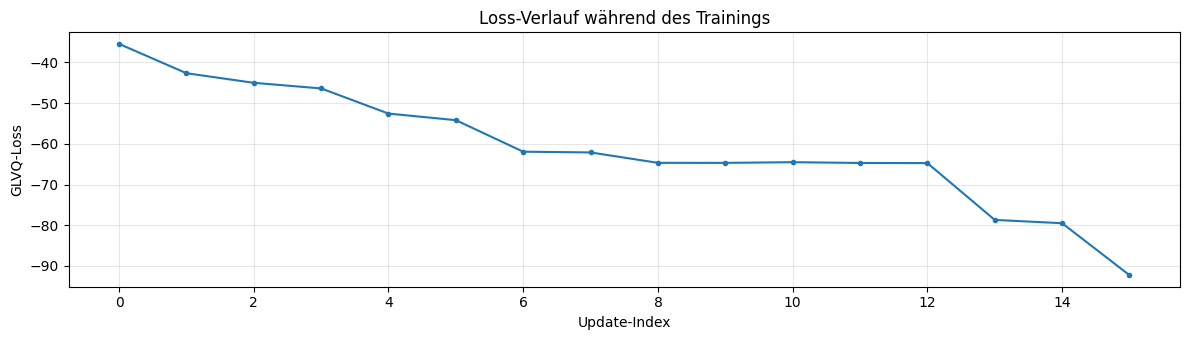

In [17]:
fig = plot_training_overview(model, smooth_v=0, show=False, return_fig=True)

/home/pmlb/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pmlb/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pmlb/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/pmlb/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


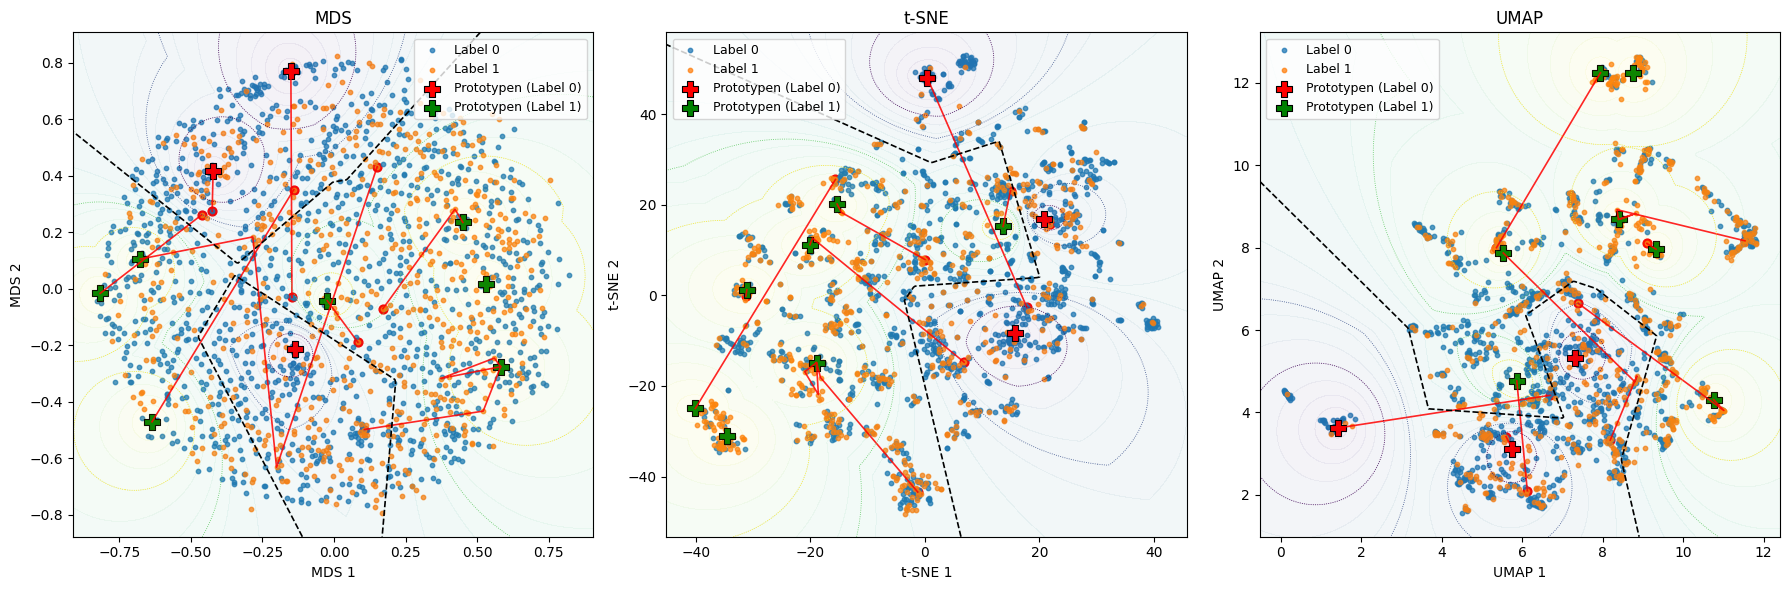

In [18]:
D = D_sorted
path = Path("embeddings/0201/one_matrix/weighted.npy")
fig, axes, embeds = visualize_from_distance_and_model(
    model, D, y,
    use_classical_mds=False,
    mds_load_path=path if path.exists() else None,
    mds_save_path="emb_store/mds_pre/A.npy"
)


## vMGLVQ

### Dietlind original

In [35]:
# 2) Optional: pro Sicht grob auf gleiche Skala bringen (sonst dominiert eine)
def robust_scale(D):
    D = D.astype(np.float32)  # spart RAM
    med = np.median(D[D > 0]) if np.any(D > 0) else 1.0
    return D / (med + 1e-12)

D_naics_scaled = robust_scale(D_naics_sub_p_aligned)
D_hs_scaled    = robust_scale(D_hs_sub_p_aligned)
D_am_scaled    = robust_scale(D_am_sub_p_aligned)
D_geo_scaled   = robust_scale(D_geo_sub_p_aligned)

# 3) DL bauen (vier Sichten)
DL = [D_naics_scaled, D_hs_scaled, D_am_scaled, D_geo_scaled]
#DL = [D_naics_sub_p_aligned, D_hs_sub_p_aligned, D_am_sub_p_aligned, D_geo_sub_p_aligned]

y = np.asarray(y_df_cut.to_numpy().astype(int))
m = len(y)

# 5) Konsistenz-Checks
for k, D in enumerate(DL, start=1):
    assert D.shape == (m, m), f"Sicht {k} hat Shape {D.shape}, erwartet {(m,m)}"
    # falls gewünscht: Diagonale 0
    np.fill_diagonal(D, 0.0)


model = vMGLVQ_dietlind(K=3,
                      T=20,
                       )

model.fit(DL, y)

print("Gelernten Sicht-Gewichte (sum=1):", model._vWeights)  # Länge 4
print("Prototyp-Indizes:", model._w)                         # Länge = K * #Klassen
print("Trainings-Accuracy:", model.score(DL, y))

[Warnung] Loss-Abweichung: erwartet -561.842, tatsächlich -539.715 (rel_err=125.595%)
Gelernten Sicht-Gewichte (sum=1): [ 2.83940894e-05 -5.29886872e-06  1.43186915e-02  9.85658213e-01]
Prototyp-Indizes: [1204  511  667 1200  233  446]
Trainings-Accuracy: 0.4183506280720918


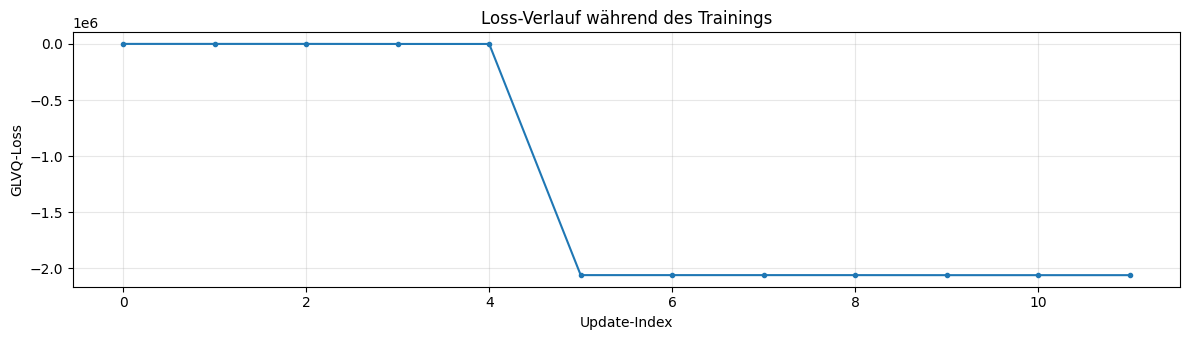

In [36]:
fig = plot_training_overview(model, smooth_v=0, show=False, return_fig=True)

/home/pmlb/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pmlb/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pmlb/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/pmlb/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


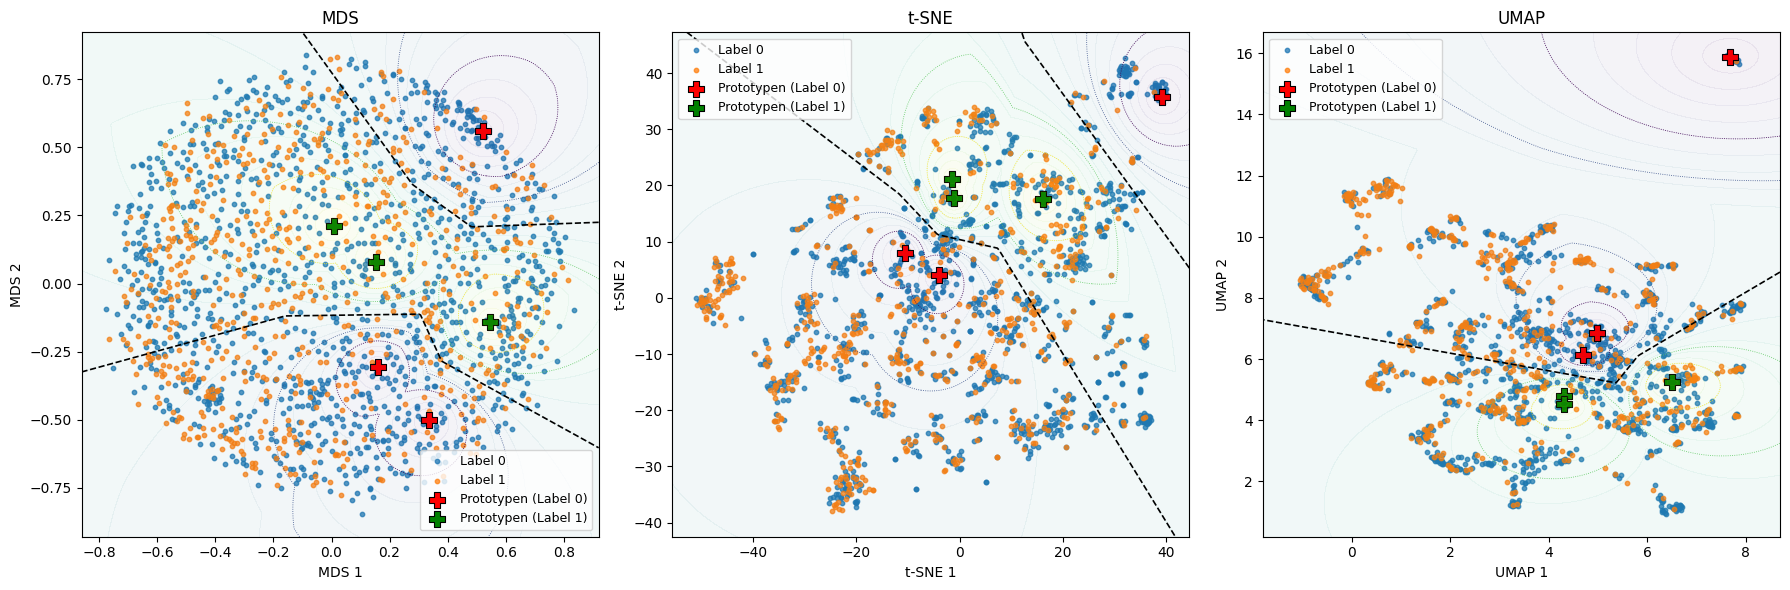

In [37]:
D = D_weighted_sub_p_aligned
path = Path("embeddings/0201/multi_matrix/weighted.npy")
fig, axes, embeds = visualize_from_distance_and_model(
    model, D, y,
    use_classical_mds=False,
    mds_load_path=path if path.exists() else None,
    mds_save_path="emb_store/mds_pre/A.npy"
)


### Dietlind & tracking

In [38]:
# 2) Optional: pro Sicht grob auf gleiche Skala bringen (sonst dominiert eine)
def robust_scale(D):
    D = D.astype(np.float32)  # spart RAM
    med = np.median(D[D > 0]) if np.any(D > 0) else 1.0
    return D / (med + 1e-12)

D_naics_scaled = robust_scale(D_naics_sub_p_aligned)
D_hs_scaled    = robust_scale(D_hs_sub_p_aligned)
D_am_scaled    = robust_scale(D_am_sub_p_aligned)
D_geo_scaled   = robust_scale(D_geo_sub_p_aligned)

# 3) DL bauen (vier Sichten)
DL = [D_naics_scaled, D_hs_scaled, D_am_scaled, D_geo_scaled]
#DL = [D_naics_sub_p_aligned, D_hs_sub_p_aligned, D_am_sub_p_aligned, D_geo_sub_p_aligned]

y = np.asarray(y_df_cut.to_numpy().astype(int))
m = len(y)

# 5) Konsistenz-Checks
for k, D in enumerate(DL, start=1):
    assert D.shape == (m, m), f"Sicht {k} hat Shape {D.shape}, erwartet {(m,m)}"
    # falls gewünscht: Diagonale 0
    np.fill_diagonal(D, 0.0)


model = vMGLVQ(K=3,
                      T=20,
                      track_path=True,     # Prototypen-Verlauf
                      track_vweights=True,    # Matrixgewichte-Verlauf
                      track_metrics=True      # Loss, dp/dm etc.
)

model.fit(DL, y)

print("Gelernten Sicht-Gewichte (sum=1):", model._vWeights)  # Länge 4
print("Prototyp-Indizes:", model._w)                         # Länge = K * #Klassen
print("Trainings-Accuracy:", model.score(DL, y))

[Warnung] Loss-Abweichung: erwartet -430.713, tatsächlich -370.015 (rel_err=123.231%)
[Warnung] Loss-Abweichung: erwartet -35947.248, tatsächlich -35918.276 (rel_err=7.452%)
Gelernten Sicht-Gewichte (sum=1): [-2.74792006e-16 -6.26503416e-24  4.67117006e-04  9.99532883e-01]
Prototyp-Indizes: [ 187  511 1251  446  175  258]
Trainings-Accuracy: 0.4576734025122884


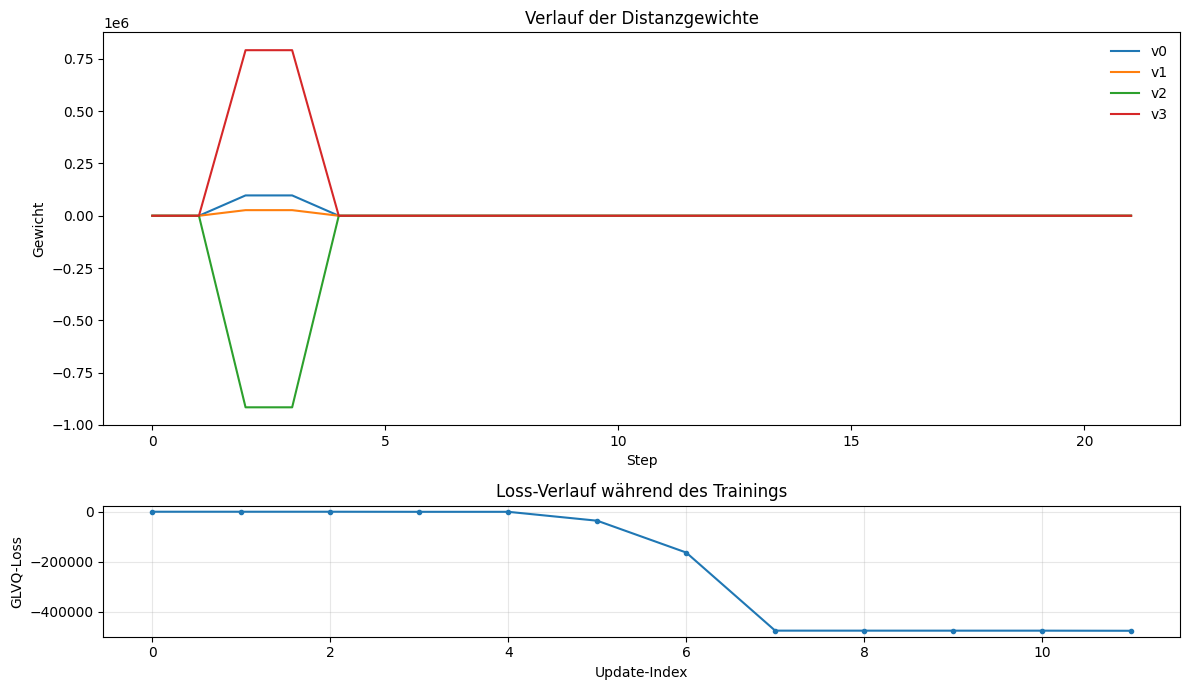

In [39]:
fig = plot_training_overview(model, smooth_v=0, show=False, return_fig=True)

/home/pmlb/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pmlb/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pmlb/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/pmlb/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


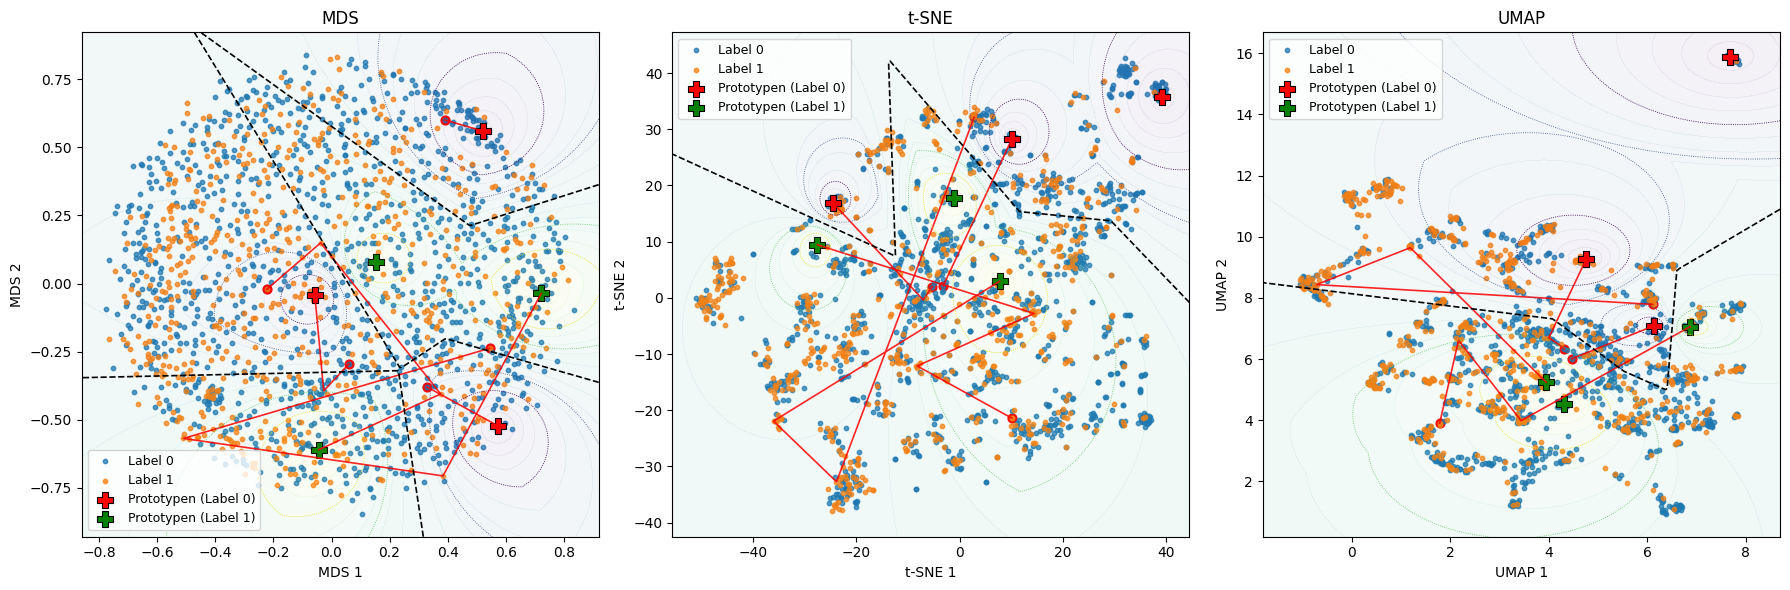

In [40]:
D = D_weighted_sub_p_aligned
path = Path("embeddings/0201/multi_matrix/weighted.npy")
fig, axes, embeds = visualize_from_distance_and_model(
    model, D, y,
    use_classical_mds=False,
    mds_load_path=path if path.exists() else None,
    mds_save_path="emb_store/mds_pre/A.npy"
)


### Angepasst

In [41]:
# 2) Optional: pro Sicht grob auf gleiche Skala bringen (sonst dominiert eine)
def robust_scale(D):
    D = D.astype(np.float32)  # spart RAM
    med = np.median(D[D > 0]) if np.any(D > 0) else 1.0
    return D / (med + 1e-12)

D_naics_scaled = robust_scale(D_naics_sub_p_aligned)
D_hs_scaled    = robust_scale(D_hs_sub_p_aligned )
D_am_scaled    = robust_scale(D_am_sub_p_aligned )
D_geo_scaled   = robust_scale(D_geo_sub_p_aligned )

# 3) DL bauen (vier Sichten)
#DL = [D_naics_scaled, D_hs_scaled, D_am_scaled, D_geo_scaled]
DL = [D_naics_sub_p_aligned, D_hs_sub_p_aligned, D_am_sub_p_aligned, D_geo_sub_p_aligned]

# 4) y in derselben Reihenfolge wie df (Länge m=1525!)
# Beispiel: falls deine Labels in df["y_col"] liegen:
y = np.asarray(y_df_cut.to_numpy().astype(int))
m = len(y)

# 5) Konsistenz-Checks
for k, D in enumerate(DL, start=1):
    assert D.shape == (m, m), f"Sicht {k} hat Shape {D.shape}, erwartet {(m,m)}"
    # falls gewünscht: Diagonale 0
    np.fill_diagonal(D, 0.0)

# 6) Modell trainieren (K = Prototypen pro Klasse; z.B. 5)
K = 3
model = vMGLVQ_uneven(K_per_class={0:3, 1:8},
                      T=50,
                      v_init=[0.3,0.2,0.4,0.1],
                      eta_v=1e-1,
                      track_path=True,     # Prototypen-Verlauf
                      track_vweights=True,    # Matrixgewichte-Verlauf
                      track_metrics=True      # Loss, dp/dm etc.
)

model.fit(DL, y)

print("Gelernten Sicht-Gewichte (sum=1):", model._vWeights)  # Länge 4
print("Prototyp-Indizes:", model._w)                         # Länge = K * #Klassen
print("Trainings-Accuracy:", model.score(DL, y))

# (Optional) Prototypen je Klasse anzeigen
for c in np.unique(y):
    proto_ids = model._w[model._y == c]
    print(f"Klasse {c}: {len(proto_ids)} Prototypen -> Indizes {proto_ids}")

[Warnung] Loss-Abweichung: erwartet -30.148, tatsächlich -27.130 (rel_err=19.196%)
[Warnung] Loss-Abweichung: erwartet -126.295, tatsächlich -120.621 (rel_err=5.902%)
[Warnung] Loss-Abweichung: erwartet -215.917, tatsächlich -164.051 (rel_err=39.840%)
Gelernten Sicht-Gewichte (sum=1): [0. 0. 1. 0.]
Prototyp-Indizes: [ 127  510 1371  759 1049  353 1366  173  313 1824 1178]
Trainings-Accuracy: 0.6029492080830148
Klasse 0: 3 Prototypen -> Indizes [ 127  510 1371]
Klasse 1: 8 Prototypen -> Indizes [ 759 1049  353 1366  173  313 1824 1178]


In [42]:
# display(model._loss)
# display(model._y)
# display(model._w)
# display(model._w_history)
# display(model.get_vweight_path())

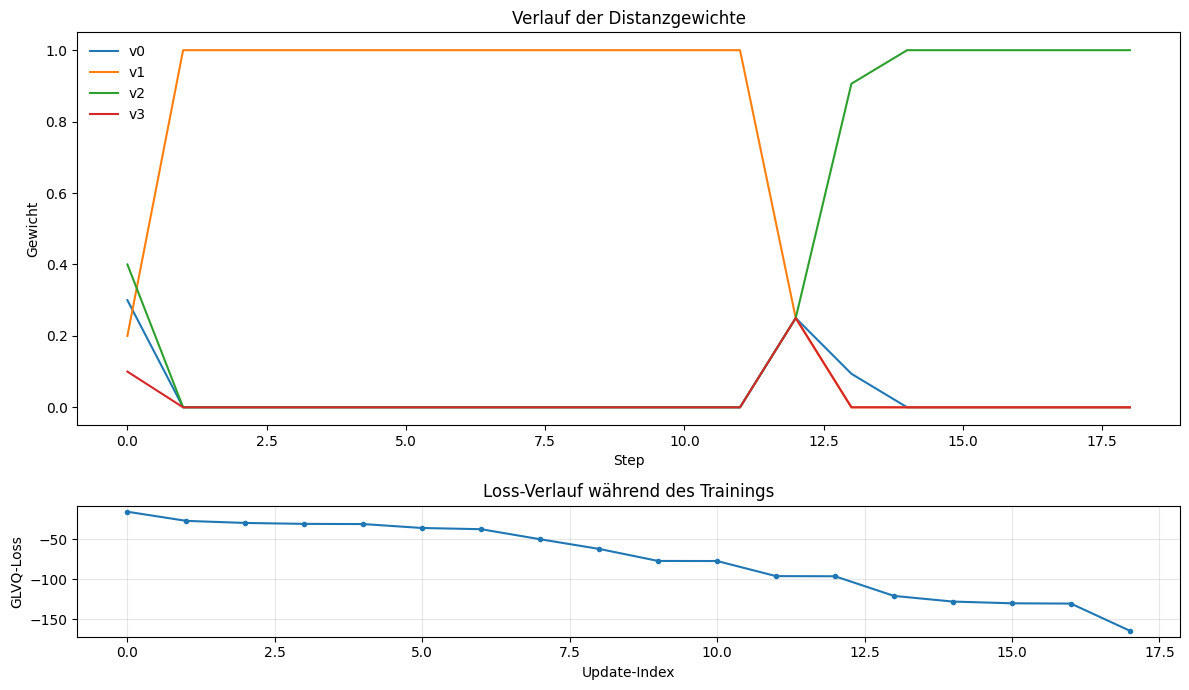

In [43]:
fig = plot_training_overview(model, smooth_v=0, show=False, return_fig=True)

/home/pmlb/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pmlb/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pmlb/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/pmlb/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


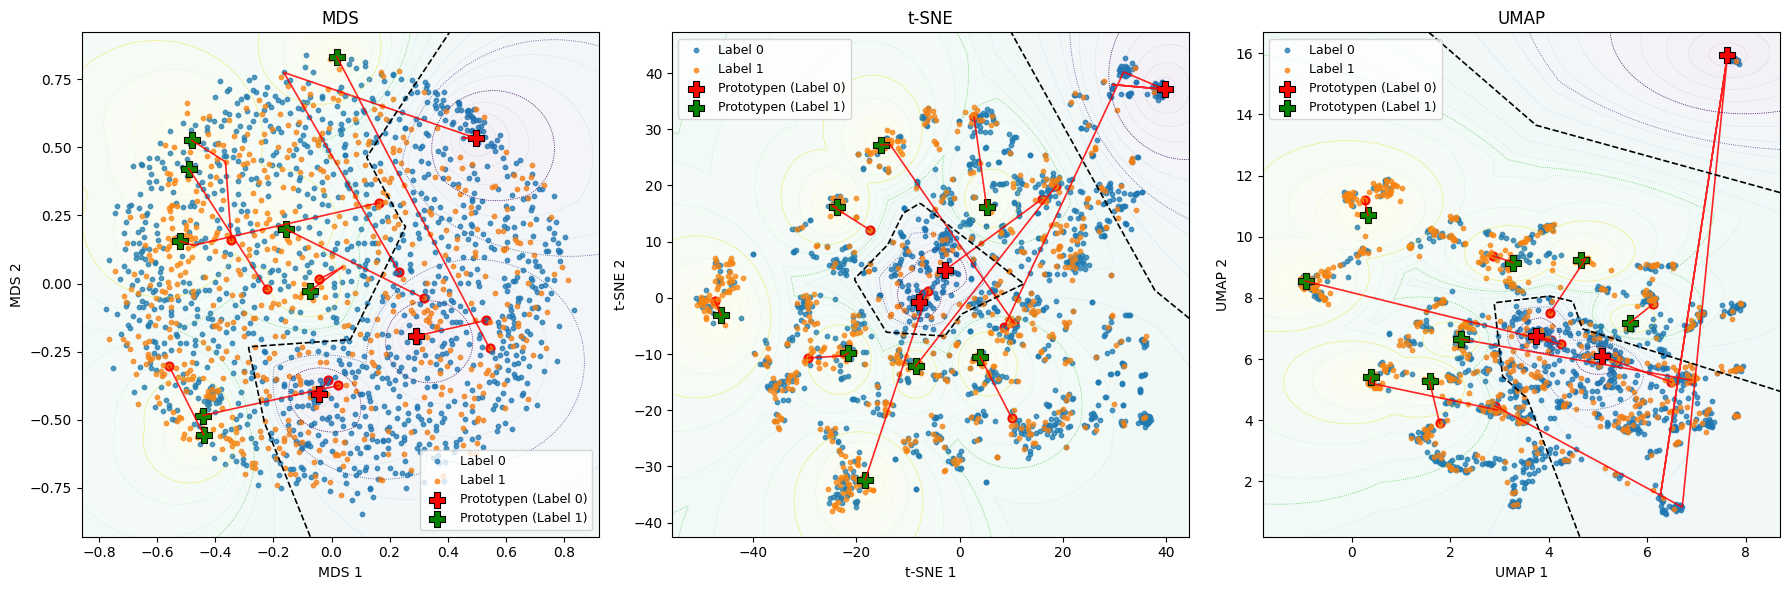

In [44]:
D = D_weighted_sub_p_aligned
path = Path("embeddings/0201/multi_matrix/weighted.npy")
fig, axes, embeds = visualize_from_distance_and_model(
    model, D, y,
    use_classical_mds=False,
    mds_load_path=path if path.exists() else None,
    mds_save_path="emb_store/mds_pre/A.npy"
)
